In [373]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import torch
import matplotlib.pyplot as plt

torch.manual_seed(298742)

In [374]:
#Load Mini MNIST from the MATLAB data file - Observe how we load the files

mnist = loadmat('mnist_49_3000.mat')
X = mnist['x']
y = mnist['y'][0]

'''
Test Train Split for Calculating accuracy on a Held Out Test Dataset.
'''
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=1000, random_state=42)


In [375]:
#We need to change -1 to 0 before fitting logistic regression.

def converter(inp):
    if inp > 0:
        return 1
    else:
        return 0

y_train_mod = np.array([converter(val) for val in y_train])
y_test_mod  = np.array([converter(val) for val in y_test])

In [376]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train_mod = torch.tensor(y_train_mod, dtype=torch.float32)
y_test_mod = torch.tensor(y_test_mod, dtype=torch.float32)

In [377]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, num_classes)
        
    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

class LogisticRegression:
    
    def __init__(self, lr=0.01, lamb = 10, num_iter=1000, fit_intercept=True):
        self.lr = lr
        self.lamb = lamb
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept

        self.model = LinearRegression(input_size=784, num_classes=1)
    
    def fit(self, X, y):

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.lamb)

        for epoch in range(self.num_iter):
            outputs = self.model(X_train)
            loss = criterion(outputs.T[0], y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    def predict(self, X, threshold=0.5):
        # return self.predict_prob(X) >= threshold
        score, _ = torch.max(self.model(X).data, 1)
        
        for i in range(len(score)):
            if score[i] < 0.5:
                score[i] = 0
            else:
                score[i] = 1
        
        return score

    def posterior_probability(self, X):
        weights = self.model.linear.state_dict()['weight']
        return 1 / (1 + torch.exp(-weights[0] @ X.T))
    

    def confidence(self, X):
        weights = self.model.linear.state_dict()['weight']  

        

In [378]:
# torch.set_printoptions(threshold=5000)
# print(y_train_mod)

def report_lambda(lamb):
    model = LogisticRegression(lr=.001, lamb=lamb)
    model.fit(X_train, y_train_mod)
    prediction = model.predict(X_test)

    num_correct = (prediction == y_test_mod).sum().item()
    accuracy = num_correct / len(y_test_mod)
    
    print(f'Test Error (lamb = {lamb}): {round((1 - accuracy) * 100, 4)}%')


report_lambda(0.001)
report_lambda(0.01)
report_lambda(0)


Test Error (lamb = 0.001): 2.4%
Test Error (lamb = 0.01): 2.4%
Test Error (lamb = 0): 2.4%


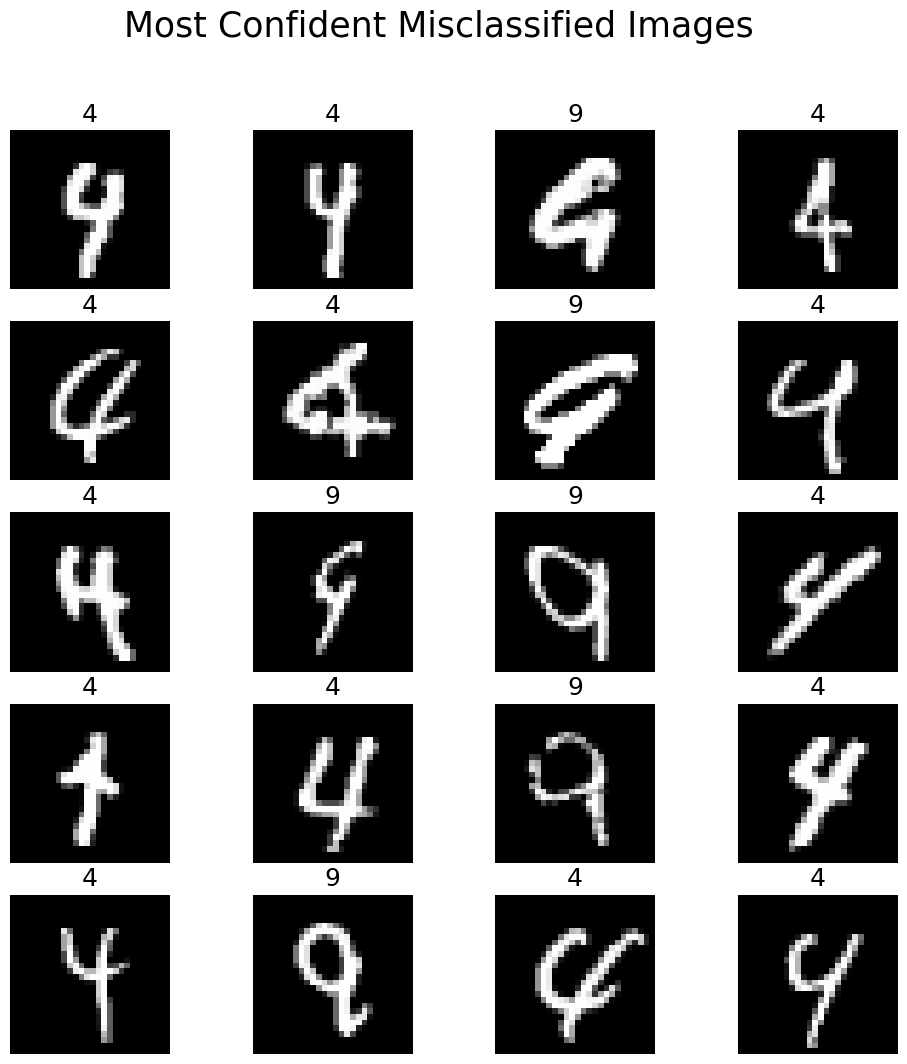

In [379]:
def normalized_confidence(index):
    confidence = confidences[index].item()

    if confidence > .5:
        return 1 - confidence
    else:
        return confidence

# Train the model

model = LogisticRegression(lr=.001, lamb=0.001)
model.fit(X_train, y_train_mod)

# Get the confidence on the test set

prediction = model.predict(X_test)
confidences = model.posterior_probability(X_test)

# Get the misclassified images and their confidences

is_correct = (prediction == y_test_mod)
misclassified = [
    (normalized_confidence(i), X_test[i], y_test[i].item()) 
    for i in range(len(prediction)) if not is_correct[i]
]

misclassified = sorted(misclassified, key=lambda v: v[0])

# Display the top 20 most confident misclassifications

plt.figure(figsize=(12,12))
plt.suptitle("Most Confident Misclassified Images", fontsize=25)

for i, (confidence, image, label) in enumerate(misclassified[:20]):
    plt.subplot(5,4,i+1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
    plt.title(9 if label == 1 else 4, fontsize=18)
    plt.axis("off")

plt.show()
plt.close()


